## Import các thư viện cần thiết

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn . model_selection import train_test_split
from sklearn . preprocessing import StandardScaler

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Tải và đọc tập dữ liệu

In [ ]:
# import the heart disease dataset
url = "heart_statlog_cleveland_hungary_final.csv"

# read the csv
dataset = pd.read_csv(url)

## Phân tích tập dữ liệu

In [ ]:
dataset.shape

In [ ]:
dataset.head()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


In [ ]:
dataset.describe()

## Tiền xử lý dữ liệu

In [ ]:
dataset.isna().sum()

In [ ]:
dataset.info()

## Chia tập train, test

In [ ]:
dataset_arr = dataset.to_numpy ().astype(np.float32 )
X, y = dataset_arr [:, :-1] , dataset_arr [:, -1]

In [ ]:
val_size = 0.1

random_state = 2
is_shuffle = True
X_train , X_val , y_train , y_val = train_test_split (X , y,test_size = val_size ,random_state = random_state ,shuffle = is_shuffle)



In [ ]:
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)
X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long)


In [ ]:
_MEAN = X_train.mean(axis=0)
_STD = X_train.std(axis=0)


X_train = ( X_train-_MEAN)/_STD
X_val = ( X_val-_MEAN)/_STD

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        # print(idx)
        return self.X[idx], self.y[idx]

In [ ]:
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)


train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)


## Model

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.linear2 = nn.Linear(hidden_dims, 128)
        self.linear3 = nn.Linear(128, 64)
        self.output = nn.Linear(64, output_dims)
        self.batchnorm1 = nn.BatchNorm1d(hidden_dims)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.batchnorm1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self. batchnorm2(x)
        x = self.relu(x)
        x = self.batchnorm2(x)
        x = self.linear3(x)
        x = self.relu(x)
        x = self.batchnorm3(x)
        out = self.output(x)
        return out.squeeze(1)


In [ ]:
model = MLP(11, 256, 2)


## Loss, Optimizer, and Evaluation Function

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 5e-4)

In [ ]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

## Huấn luyện mô hình

In [ ]:
# some parameter
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 300

In [ ]:
# train
best_accuracy = 0.0
for epoch in range(max_epoch):
    running_loss = 0.0
    running_correct = 0   # to track number of correct predictions
    total = 0             # to track total number of samples

    for i, (inputs, labels) in enumerate(train_loader, 0):
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)


        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Determine class predictions and track accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)
    test_loss, test_accuracy = evaluate(model, val_loader, criterion)
    print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    # save for plot
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    #save weight model
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), 'best_model.pth')

Epoch [1/300], Loss: 0.5140, Accuracy: 73.02%, Test Loss: 0.6058, Test Accuracy: 86.55%
Epoch [2/300], Loss: 0.5756, Accuracy: 84.13%, Test Loss: 0.5220, Test Accuracy: 87.39%
Epoch [3/300], Loss: 0.4991, Accuracy: 84.59%, Test Loss: 0.4251, Test Accuracy: 85.71%
Epoch [4/300], Loss: 0.4188, Accuracy: 84.87%, Test Loss: 0.3569, Test Accuracy: 85.71%
Epoch [5/300], Loss: 0.3685, Accuracy: 84.50%, Test Loss: 0.3328, Test Accuracy: 85.71%
Epoch [6/300], Loss: 0.3741, Accuracy: 84.69%, Test Loss: 0.3225, Test Accuracy: 85.71%
Epoch [7/300], Loss: 0.3790, Accuracy: 84.97%, Test Loss: 0.3093, Test Accuracy: 87.39%
Epoch [8/300], Loss: 0.3213, Accuracy: 85.81%, Test Loss: 0.3003, Test Accuracy: 89.08%
Epoch [9/300], Loss: 0.3458, Accuracy: 85.99%, Test Loss: 0.2964, Test Accuracy: 89.08%
Epoch [10/300], Loss: 0.3373, Accuracy: 87.02%, Test Loss: 0.2905, Test Accuracy: 89.08%
Epoch [11/300], Loss: 0.3036, Accuracy: 88.05%, Test Loss: 0.2797, Test Accuracy: 87.39%
Epoch [12/300], Loss: 0.2985, 

## Đánh giá mô hình

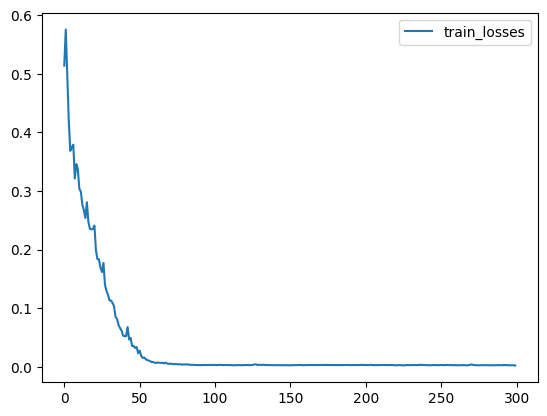

In [ ]:
plt.plot(train_losses, label='train_losses')
plt.legend()

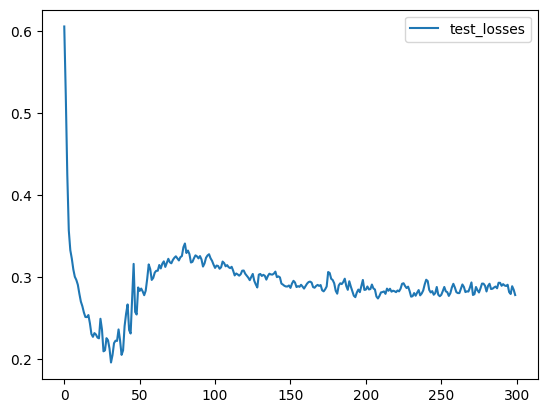

In [ ]:
plt.plot(test_losses, label='test_losses')
plt.legend()

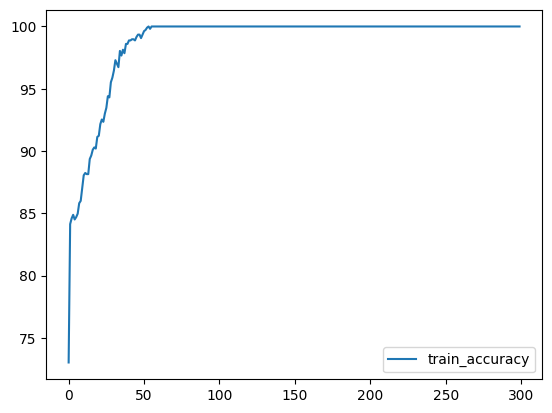

In [ ]:
plt.plot(train_accuracies, label='train_accuracy')
plt.legend()

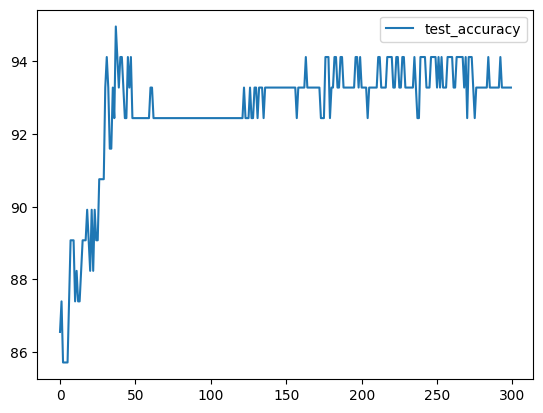

In [ ]:
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()